<a href="https://colab.research.google.com/github/Allen123321/DEMO-DL/blob/master/30_days_deep_learning_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 6-2,训练模型的3种方法
模型的训练主要有内置fit方法、内置tran_on_batch方法、自定义训练循环。<br>
注：fit_generator方法在tf.keras中不推荐使用，其功能已经被fit包含。


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import *
#打印时间分割线
@tf.function
def printbar():
    today_ts = tf.timestamp()%(24*60*60)

    hour = tf.cast(today_ts//3600+2,tf.int32)%tf.constant(24)
    minite = tf.cast((today_ts%3600)//60,tf.int32)
    second = tf.cast(tf.floor(today_ts%60),tf.int32)
    
    def timeformat(m):
        if tf.strings.length(tf.strings.format("{}",m))==1:
            return(tf.strings.format("0{}",m))
        else:
            return(tf.strings.format("{}",m))
    
    timestring = tf.strings.join([timeformat(hour),timeformat(minite),
                timeformat(second)],separator = ":")
    tf.print("=========="*8+timestring)

In [2]:
MAX_LEN = 300
BATCH_SIZE = 32
(x_train,y_train),(x_test,y_test) = datasets.reuters.load_data()
x_train = preprocessing.sequence.pad_sequences(x_train,maxlen=MAX_LEN) # Pads sequences to the same length.
x_test = preprocessing.sequence.pad_sequences(x_test,maxlen=MAX_LEN)

MAX_WORDS = x_train.max()+1
CAT_NUM = y_train.max()+1

2113536/2110848 [==============================] - 0s 0us/step


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [7]:
ds_train = tf.data.Dataset.from_tensor_slices((x_train,y_train)) \
          .shuffle(buffer_size = 1000).batch(BATCH_SIZE) \
          .prefetch(tf.data.experimental.AUTOTUNE).cache()
   
ds_test = tf.data.Dataset.from_tensor_slices((x_test,y_test)) \
          .shuffle(buffer_size = 1000).batch(BATCH_SIZE) \
          .prefetch(tf.data.experimental.AUTOTUNE).cache() 
          
# 使用 prefetch 方法让数据准备和参数迭代两个过程相互并行。

#使用 cache 方法让数据在第一个epoch后缓存到内存中，仅限于数据集不大情形。

## 一，内置fit方法
该方法功能非常强大, 支持对numpy array, tf.data.Dataset以及 Python generator数据进行训练。

并且可以通过设置回调函数实现对训练过程的复杂控制逻辑。

In [8]:
tf.keras.backend.clear_session()
def create_model():
  model = models.Sequential()
  model.add(layers.Embedding(MAX_WORDS,7,input_length=MAX_LEN))
  model.add(layers.Conv1D(filters = 64,kernel_size = 5,activation = "relu"))
  model.add(layers.MaxPool1D(2))
  model.add(layers.Conv1D(filters = 32,kernel_size = 3,activation = "relu"))
  model.add(layers.MaxPool1D(2))
  model.add(layers.Flatten())
  model.add(layers.Dense(CAT_NUM,activation = "softmax"))
  return(model)

def compile_model(model):
  model.compile(optimizer=optimizers.Nadam(),
                loss=losses.SparseCategoricalCrossentropy(),
                metrics=[metrics.SparseCategoricalAccuracy(),metrics.SparseTopKCategoricalAccuracy(5)]) 
  return(model)

model = create_model()
model.summary()
model = compile_model(model)
                

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 7)            216874    
_________________________________________________________________
conv1d (Conv1D)              (None, 296, 64)           2304      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 148, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 146, 32)           6176      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 73, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 2336)              0         
_________________________________________________________________
dense (Dense)                (None, 46)                1

In [9]:
history = model.fit(ds_train,validation_data = ds_test,epochs = 10)

Epoch 1/10
281/281 [==============================] - 9s 29ms/step - loss: 2.3841 - sparse_categorical_accuracy: 0.3980 - sparse_top_k_categorical_accuracy: 0.7151 - val_loss: 1.7610 - val_sparse_categorical_accuracy: 0.5463 - val_sparse_top_k_categorical_accuracy: 0.7596
Epoch 2/10
281/281 [==============================] - 8s 28ms/step - loss: 1.6231 - sparse_categorical_accuracy: 0.5821 - sparse_top_k_categorical_accuracy: 0.7786 - val_loss: 1.5976 - val_sparse_categorical_accuracy: 0.5819 - val_sparse_top_k_categorical_accuracy: 0.7827
Epoch 3/10
281/281 [==============================] - 8s 28ms/step - loss: 1.2944 - sparse_categorical_accuracy: 0.6672 - sparse_top_k_categorical_accuracy: 0.8278 - val_loss: 1.6088 - val_sparse_categorical_accuracy: 0.6122 - val_sparse_top_k_categorical_accuracy: 0.7983
Epoch 4/10
281/281 [==============================] - 8s 28ms/step - loss: 1.0285 - sparse_categorical_accuracy: 0.7319 - sparse_top_k_categorical_accuracy: 0.8855 - val_loss: 1.764

In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

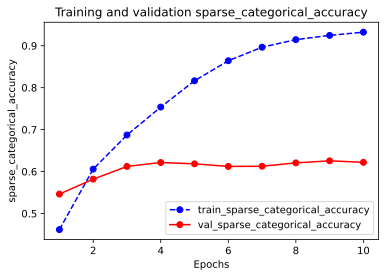

In [29]:
plot_metric(history,"sparse_categorical_accuracy")

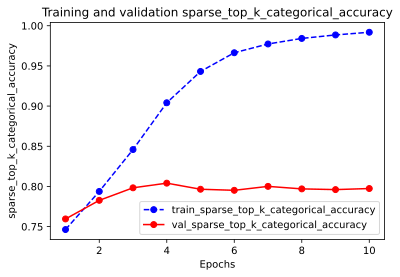

In [30]:
plot_metric(history,"sparse_top_k_categorical_accuracy")

## 二，内置train_on_batch方法
该内置方法相比较fit方法更加灵活，可以不通过回调函数而直接在批次层次上更加精细地控制训练的过程。

In [31]:
tf.keras.backend.clear_session()

def create_model():
    model = models.Sequential()

    model.add(layers.Embedding(MAX_WORDS,7,input_length=MAX_LEN))
    model.add(layers.Conv1D(filters = 64,kernel_size = 5,activation = "relu"))
    model.add(layers.MaxPool1D(2))
    model.add(layers.Conv1D(filters = 32,kernel_size = 3,activation = "relu"))
    model.add(layers.MaxPool1D(2))
    model.add(layers.Flatten())
    model.add(layers.Dense(CAT_NUM,activation = "softmax"))
    return(model)

def compile_model(model):
    model.compile(optimizer=optimizers.Nadam(),
                loss=losses.SparseCategoricalCrossentropy(),
                metrics=[metrics.SparseCategoricalAccuracy(),metrics.SparseTopKCategoricalAccuracy(5)]) 
    return(model)
 
model = create_model()
model.summary()
model = compile_model(model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 7)            216874    
_________________________________________________________________
conv1d (Conv1D)              (None, 296, 64)           2304      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 148, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 146, 32)           6176      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 73, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 2336)              0         
_________________________________________________________________
dense (Dense)                (None, 46)                1

In [32]:
def train_model(model,ds_train,ds_valid,epoches):
  for epoch in tf.range(1,epoches+1):
    model.reset_metrics()
    # 在后期降低学习率
    if epoch == 5:
      model.optimizer.lr.assign(model.optimizer.lr/2.0)
      tf.print("Lowering optimizer Learning Rate...\n\n")

    for x, y in ds_train:
      train_result = model.train_on_batch(x, y)

    for x, y in ds_valid:
      valid_result = model.test_on_batch(x, y,reset_metrics=False)

    if epoch%1 ==0:
      printbar()
      tf.print("epoch = ",epoch)
      print("train:",dict(zip(model.metrics_names,train_result)))
      print("valid:",dict(zip(model.metrics_names,valid_result)))
      print("")

In [37]:
train_model(model,ds_train,ds_test,10)

================================================================================11:50:31
epoch =  1
train: {'loss': 1.3767461776733398, 'sparse_categorical_accuracy': 0.5909090638160706, 'sparse_top_k_categorical_accuracy': 0.9090909361839294}
valid: {'loss': 1.5933196544647217, 'sparse_categorical_accuracy': 0.5837043523788452, 'sparse_top_k_categorical_accuracy': 0.7809438705444336}

================================================================================11:50:40
epoch =  2
train: {'loss': 1.1801460981369019, 'sparse_categorical_accuracy': 0.6818181872367859, 'sparse_top_k_categorical_accuracy': 0.9090909361839294}
valid: {'loss': 1.6016020774841309, 'sparse_categorical_accuracy': 0.6073018908500671, 'sparse_top_k_categorical_accuracy': 0.8000890612602234}

================================================================================11:50:49
epoch =  3
train: {'loss': 1.0590027570724487, 'sparse_categorical_accuracy': 0.7272727489471436, 'sparse_top_k_categorical_accuracy'

## 三，自定义训练循环
自定义训练循环无需编译模型，直接利用优化器根据损失函数反向传播迭代参数，拥有最高的灵活性。

In [38]:
tf.keras.backend.clear_session()

def create_model():
    
    model = models.Sequential()

    model.add(layers.Embedding(MAX_WORDS,7,input_length=MAX_LEN))
    model.add(layers.Conv1D(filters = 64,kernel_size = 5,activation = "relu"))
    model.add(layers.MaxPool1D(2))
    model.add(layers.Conv1D(filters = 32,kernel_size = 3,activation = "relu"))
    model.add(layers.MaxPool1D(2))
    model.add(layers.Flatten())
    model.add(layers.Dense(CAT_NUM,activation = "softmax"))
    return(model)

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 7)            216874    
_________________________________________________________________
conv1d (Conv1D)              (None, 296, 64)           2304      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 148, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 146, 32)           6176      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 73, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 2336)              0         
_________________________________________________________________
dense (Dense)                (None, 46)                1

In [39]:
optimizer = optimizers.Nadam()
loss_func = losses.SparseCategoricalCrossentropy()
train_loss = metrics.Mean(name='train_loss')
train_metric = metrics.SparseCategoricalAccuracy(name='train_accuracy')


valid_loss = metrics.Mean(name='valid_loss')
valid_metric = metrics.SparseCategoricalAccuracy(name='valid_accuracy')

@tf.function
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features,training = True)
        loss = loss_func(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss.update_state(loss)
    train_metric.update_state(labels, predictions)

@tf.function
def valid_step(model, features, labels):
    predictions = model(features)
    batch_loss = loss_func(labels, predictions)
    valid_loss.update_state(batch_loss)
    valid_metric.update_state(labels, predictions)

def train_model(model,ds_train,ds_valid,epochs):
    for epoch in tf.range(1,epochs+1):
        
        for features, labels in ds_train:
            train_step(model,features,labels)

        for features, labels in ds_valid:
            valid_step(model,features,labels)

        logs = 'Epoch={},Loss:{},Accuracy:{},Valid Loss:{},Valid Accuracy:{}'
        
        if epoch%1 ==0:
            printbar()
            tf.print(tf.strings.format(logs,
            (epoch,train_loss.result(),train_metric.result(),valid_loss.result(),valid_metric.result())))
            tf.print("")
            
        train_loss.reset_states()
        valid_loss.reset_states()
        train_metric.reset_states()
        valid_metric.reset_states()

train_model(model,ds_train,ds_test,10)


================================================================================11:59:10
Epoch=1,Loss:2.0140028,Accuracy:0.478957921,Valid Loss:1.6958425,Valid Accuracy:0.554764032

================================================================================11:59:17
Epoch=2,Loss:1.47327614,Accuracy:0.619349837,Valid Loss:1.56854141,Valid Accuracy:0.587711513

================================================================================11:59:24
Epoch=3,Loss:1.18837869,Accuracy:0.686706722,Valid Loss:1.59362626,Valid Accuracy:0.618878

================================================================================11:59:31
Epoch=4,Loss:0.924840748,Accuracy:0.756847,Valid Loss:1.75251126,Valid Accuracy:0.6197685

================================================================================11:59:38
Epoch=5,Loss:0.694776773,Accuracy:0.820863962,Valid Loss:1.97919953,Valid Accuracy:0.621104181

================================================================================11:59:45